<a href="https://colab.research.google.com/github/elvissoares/COQ878-QuiQuaComp/blob/main/notebooks/notebook_Aula_MACE_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Force Field usando MACE e ASE no Google Colab

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares)

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Nesse tutorial iremos aprender como melhorar modelos de MLIP usando modelos de estado da arte como [foundation models](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) baseados na arquitetura [MACE](https://mace-docs.readthedocs.io/en/latest/index.html). Discutiremos também como realizar o [fine tunning](https://mace-docs.readthedocs.io/en/latest/guide/finetuning.html) do modelo com novos cálculos ab initio realizados com VASP.

> Lembre-se de usar a máquina `T4` ou outra com GPU no Colab

## Passo -1: Instalar MACE e suas dependências

No colab devemos instalar o MACE e algumas dependências. O pacote `torch` já está instalado automaticamente.

In [ ]:
!pip install --upgrade ase numpy==2.0 -q
!pip install git+https://github.com/imagdau/aseMolec@f411b5618381ba3b807cbbb041f12f460a69d606 -q
!pip install mace-torch cuequivariance cuequivariance-torch cuequivariance-ops-torch-cu12 torch-dftd -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 117.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.1/237.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.7/266.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.7/681.7 kB 46.1 MB/s eta 0:

Carregando os pacotes necessários

In [ ]:
import os
from ase.io import write, read
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation

import time
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

## Passo 0: Criando uma função auxiliar que faz dinâmica Molecular no ASE

In [ ]:
np.random.seed(701) #fazendo com que os resultados sejam reprodutíveis

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.calc = calc

    #initialize the temperature

    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 0.5*units.fs, temperature_K=temp, friction=0.005/units.fs) #drive system to desired temperature

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = plt.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.info['energy_mace'] = dyn.atoms.get_potential_energy()
            dyn.atoms.arrays['forces_mace'] = dyn.atoms.calc.get_forces()
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Passo 1: Fazendo MD usando _foundation models_ from MACE

Os modelos fundamentais mudaram tudo. O MACE-MP-0 é um modelo treinado com mais de 1 milhão de cálculos de DFT e é capaz de rodar dinâmicas para toda a tabela periódica.

O MACE fornece uma interface simples para carregar um modelo fundamental, que podemos usar agora. Consulte a [documentação](https://mace-docs.readthedocs.io/en/latest/guide/foundation_models.html) para mais detalhes.

In [ ]:
from mace.calculators import mace_mp

macemp = mace_mp(model="small", dispersion=True, default_dtype = "float32", device="cuda")

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Cached MACE model to /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using Materials Project MACE for MACECalculator with /root/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.


/usr/local/lib/python3.12/dist-packages/mace/calculators/mace.py:197: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  torch.load(f=model_path, map_location=device)


Using head Default out of ['Default']
Default dtype float32 does not match model dtype float64, converting models to float32.
Using TorchDFTD3Calculator for D3 dispersion corrections


Carregando arquivo de configuração inicial do sistema (usei um arquivo que se encontra no meu Github)

In [ ]:
!wget https://raw.githubusercontent.com/elvissoares/COQ878-QuiQuaComp/refs/heads/main/notebooks/mace/ic_32h2o_300K.pdb

--2025-12-04 15:11:36--  https://raw.githubusercontent.com/elvissoares/COQ878-QuiQuaComp/refs/heads/main/notebooks/mace/ic_32h2o_300K.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7854 (7.7K) [text/plain]
Saving to: ‘ic_32h2o_300K.pdb’

ic_32h2o_300K.pdb   100%[===================>]   7.67K  --.-KB/s    in 0s      

2025-12-04 15:11:36 (118 MB/s) - ‘ic_32h2o_300K.pdb’ saved [7854/7854]



Criando diretório `mace`

In [ ]:
!mkdir mace

Carregando arquivo de configuração inicial para rodar MD

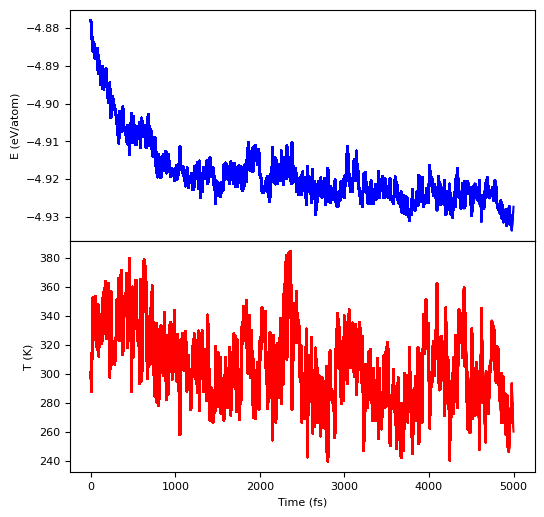

MD finished in 47.09 minutes!


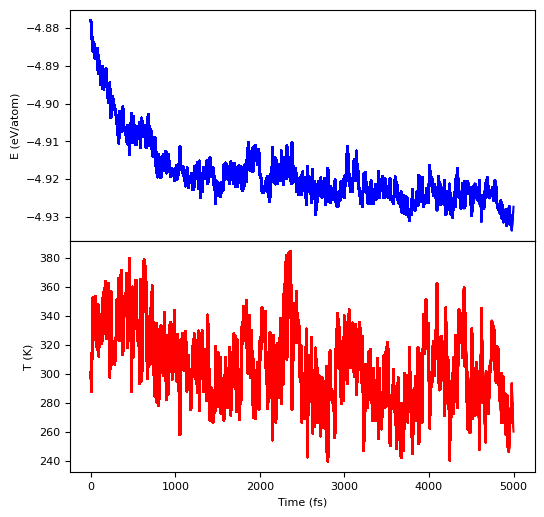

In [ ]:
init_conf = read('ic_32h2o_300K.pdb')

simpleMD(init_conf, temp=300, calc=macemp, fname='mace/mace_md_32h2o_300K.xyz', s=10, T=10000)

> Demorou ~47 min, comparados com os 880 minutos do cálculo Ab Initio feito usando o VASP na Aula 07.

### Analisando a energia da trajetória

Carregando arquivo para comparar as energias.

Text(0.5, 0, 'Density Prob.')

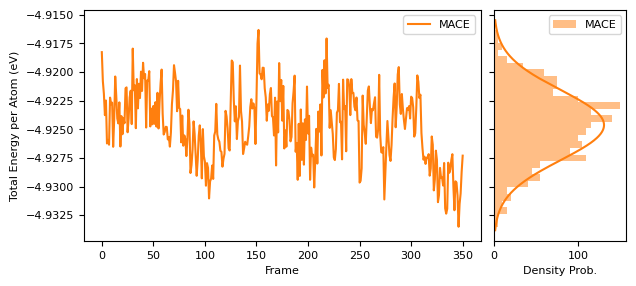

In [ ]:
from aseMolec import extAtoms as ea

traj0 = read('mace/mace_md_32h2o_300K.xyz', '50:')

# cortando a parte inicial da simulação (fora do equilíbrio)
traj = traj0[600:]
frames = np.arange(len(traj))
mace_energies = ea.get_prop(traj, 'info', 'energy_mace', peratom=True)

fig, axs = plt.subplots(1, 2,figsize=(7,3), sharey=True, gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05} )

axs[0].plot(frames, mace_energies, label='MACE', color='C1')
axs[0].legend()
axs[0].set_xlabel('Frame')
axs[0].set_ylabel('Total Energy per Atom (eV)')

axs[1].hist(mace_energies,bins=30,density=True, color='C1', alpha=0.5, label='MACE', orientation="horizontal")

Umean = np.mean(mace_energies)
sigmaU = np.std(mace_energies)
uarray = Umean+np.arange(-3*sigmaU,3*sigmaU,0.01*sigmaU)
axs[1].plot(np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),uarray, color='C1')

axs[1].legend()
axs[1].set_xlabel('Density Prob.')